- [Normalizer](#Normalizer)
- [RobustScaler](#RobustScaler)

In [35]:
from sklearn.feature_selection import SelectFromModel #SelectFromModel import
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from numpy import mean, std
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.under_sampling import NearMiss
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

default_dir = '/home/users/s17011720/predicting_impression_using_mobile_game/'

In [3]:
train = pd.read_csv(default_dir + "extract_features_data/train_data.csv")
test = pd.read_csv(default_dir + "extract_features_data/test_data.csv")

In [4]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [5]:
target_y = pd.read_csv(default_dir + "extract_features_data/target_y.csv")
target_y.shape

(58035, 4)

In [6]:
target_y.fillna(0, inplace=True)
target_y.head(2)

,ad_id,ba_imps_234567,is_imps_234567,rv_imps_234567
0,00038635-61d2-4656-b04b-332c5a6755cd,1.0,0.0,0.0
1,0003b43c-1404-4ece-9cb2-3971a24612da,1.0,0.0,0.0


In [7]:
target_y['eCPM'] = target_y['ba_imps_234567']*1.11 + target_y['is_imps_234567']*18.3 + target_y['rv_imps_234567']*22.81
target_y = target_y[['ad_id', 'eCPM']]

In [8]:
day_time_01 = pd.read_csv(default_dir + "extract_features_data/day_time_01.csv")
day_time_01.head(2)

,ad_id,day_time_sum_0,day_time_mean_0,day_time_sum_1,day_time_mean_1
0,00018501-6eee-45e9-b5b5-7b50f966abd8,33.122002,33.122002,NaN,NaN
1,0001edb6-e7e7-4f74-8993-2bfc9347a959,584.755000,584.755000,NaN,NaN


In [9]:
day_time_cols = ['day_time_sum_0', 'day_time_mean_0', 'day_time_sum_1', 'day_time_mean_1']

In [10]:
target_y = pd.merge(target_y, day_time_01, on=['ad_id'], how='left')
target_y.head(2)

,ad_id,eCPM,day_time_sum_0,day_time_mean_0,day_time_sum_1,day_time_mean_1
0,00038635-61d2-4656-b04b-332c5a6755cd,1.11,2373.133001,1186.566501,2168.193,2168.193
1,0003b43c-1404-4ece-9cb2-3971a24612da,1.11,57.616001,57.616001,NaN,NaN


In [11]:
train.drop(day_time_cols, axis=1, inplace=True)
test.drop(day_time_cols, axis=1, inplace=True)

In [12]:
train_df = pd.merge(train, target_y, on=['ad_id'], how='left')
test_df = pd.merge(test, target_y, on=['ad_id'], how='left')

In [13]:
train_df.head(2)

,ad_id,in_coin_cnt_0,out_coin_cnt_0,in_coin_sum_0,out_coin_sum_0,curr_var_min_0,curr_var_max_0,buy_skin_var_sum_0,offline_coin_var_sum_0,play_var_sum_0,...,pinch_cnt_1,clear/stage_cnt_0,clear/stage_cnt_1,session_count_0,session_count_1,eCPM,day_time_sum_0,day_time_mean_0,day_time_sum_1,day_time_mean_1
0,00018501-6eee-45e9-b5b5-7b50f966abd8,1.0,0.0,51.0,0.0,51.0,51.0,0.0,0.0,51.0,...,0.0,100.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN
1,0001ef07-c27e-4d91-a8bb-d0aa5f0d45e7,3.0,0.0,153.0,0.0,51.0,153.0,0.0,0.0,153.0,...,2.0,100.0,100.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN


In [14]:
train_y = train_df[['ad_id', 'eCPM']]
test_y = test_df[['ad_id', 'eCPM']]

In [15]:
print(len(train_y))
print(len(test_y))

180040
45011


In [16]:
df_y = pd.concat([train_y, test_y], ignore_index=True)
df_y.head(2)

,ad_id,eCPM
0,00018501-6eee-45e9-b5b5-7b50f966abd8,NaN
1,0001ef07-c27e-4d91-a8bb-d0aa5f0d45e7,NaN


In [17]:
df_y.fillna(0, inplace=True)

In [18]:
df_y['eCPM_class'] = 0 
df_y.loc[df_y['eCPM']>0, 'eCPM_class']=1

<AxesSubplot:xlabel='eCPM_class', ylabel='count'>

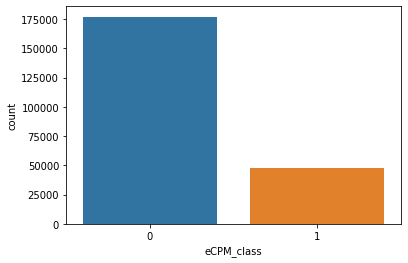

In [19]:
sns.countplot(x="eCPM_class", data=df_y)

In [20]:
df_y=df_y[['ad_id', 'eCPM_class']]

In [21]:
train_df = pd.merge(train_df, df_y, on=['ad_id'], how='left')
train_df.head(2)

,ad_id,in_coin_cnt_0,out_coin_cnt_0,in_coin_sum_0,out_coin_sum_0,curr_var_min_0,curr_var_max_0,buy_skin_var_sum_0,offline_coin_var_sum_0,play_var_sum_0,...,clear/stage_cnt_0,clear/stage_cnt_1,session_count_0,session_count_1,eCPM,day_time_sum_0,day_time_mean_0,day_time_sum_1,day_time_mean_1,eCPM_class
0,00018501-6eee-45e9-b5b5-7b50f966abd8,1.0,0.0,51.0,0.0,51.0,51.0,0.0,0.0,51.0,...,100.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0
1,0001ef07-c27e-4d91-a8bb-d0aa5f0d45e7,3.0,0.0,153.0,0.0,51.0,153.0,0.0,0.0,153.0,...,100.0,100.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,0


In [22]:
test_df = pd.merge(test_df, df_y, on=['ad_id'], how='left')

In [23]:
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [24]:
train_df.head(2)

,ad_id,in_coin_cnt_0,out_coin_cnt_0,in_coin_sum_0,out_coin_sum_0,curr_var_min_0,curr_var_max_0,buy_skin_var_sum_0,offline_coin_var_sum_0,play_var_sum_0,...,clear/stage_cnt_0,clear/stage_cnt_1,session_count_0,session_count_1,eCPM,day_time_sum_0,day_time_mean_0,day_time_sum_1,day_time_mean_1,eCPM_class
0,00018501-6eee-45e9-b5b5-7b50f966abd8,1.0,0.0,51.0,0.0,51.0,51.0,0.0,0.0,51.0,...,100.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0
1,0001ef07-c27e-4d91-a8bb-d0aa5f0d45e7,3.0,0.0,153.0,0.0,51.0,153.0,0.0,0.0,153.0,...,100.0,100.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,0


In [25]:
train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

In [26]:
not_feature = ['ad_id', 'eCPM', 'eCPM_class']
X_train = train_df.drop(not_feature, axis=1)
X_test = test_df.drop(not_feature, axis=1)

Y_train = train_df[['eCPM_class']]
Y_test = test_df[['eCPM_class']]
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(180040, 222) (180040, 1)
(45011, 222) (45011, 1)


## feature selection

In [59]:
selector = SelectKBest(chi2, k=10)
selector.fit(X_train, Y_train)
# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)
features_df_new = X_train.iloc[:,cols]

In [60]:
features_df_new.columns

Index(['curr_var_max_0', 'coin_minmax_diff_0', 'in_coin_sum_1',
       'out_coin_sum_1', 'play_var_sum_1', 'coin_sum_1', 'day_time_sum_0',
       'day_time_mean_0', 'day_time_sum_1', 'day_time_mean_1'],
      dtype='object')

In [61]:
df = train_df[features_df_new.columns.tolist()]

In [62]:
df['class']=train_df['eCPM_class']

In [63]:
df.corr()['class']

curr_var_max_0       -0.002057
coin_minmax_diff_0   -0.002057
in_coin_sum_1         0.165130
out_coin_sum_1        0.131076
play_var_sum_1        0.152631
coin_sum_1            0.150528
day_time_sum_0        0.448776
day_time_mean_0       0.412676
day_time_sum_1        0.190668
day_time_mean_1       0.175447
class                 1.000000
Name: class, dtype: float64

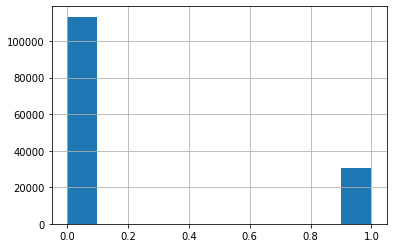

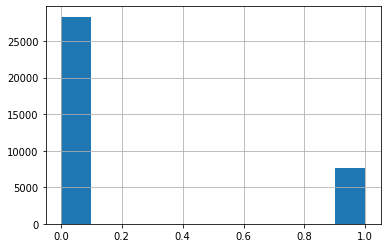

In [64]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(features_df_new, Y_train):
    x_train = features_df_new.loc[train_index]
    x_val = features_df_new.loc[test_index]
    
    y_train = Y_train.loc[train_index]
    y_val = Y_train.loc[test_index]
    
y_train["eCPM_class"].hist()
plt.show()
y_val["eCPM_class"].hist()
plt.show()

In [65]:
scalar = StandardScaler()

x_train_scaled = scalar.fit_transform(x_train)
x_val_scaled = scalar.fit_transform(x_val)

In [66]:
X_test_scaled = scalar.fit_transform(X_test[features_df_new.columns.tolist()])

In [33]:
nm = NearMiss()
x_nm, y_nm = nm.fit_resample(x_train_scaled, y_train)
print(x_nm.shape, y_nm.shape)

KeyboardInterrupt: 

In [ ]:
scores = {}
acc = []
cv_scores = []
def model(x_train, y_train, x_test, y_test):
    model = XGBClassifier()
    model.fit(x_train, y_train)
    score = model.score(x_test, y_test)
    print("Accuracy: {}".format(score))
    cv_score = cross_val_score(model, x_train, y_train, cv=5, scoring='f1')
    print("Cross Val Score: {}".format(np.mean(cv_score)))
    acc.append(score)
    cv_scores.append(np.mean(cv_score))
    y_pred = model.predict(x_test)
    
    return model, y_pred

In [67]:
from xgboost import XGBClassifier
clf = XGBClassifier()
clf.fit(x_train, y_train)

[19:38:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=40, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [69]:
y_val_pred = clf.predict(x_val_scaled)

Normalized confusion matrix
[[0.96 0.04]
 [0.25 0.75]]
Confusion matrix, without normalization
[[27170  1150]
 [ 1940  5748]]


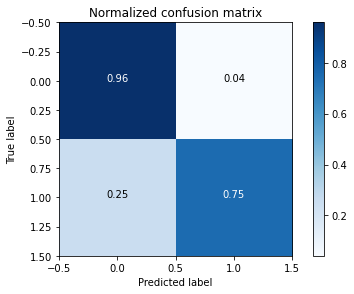

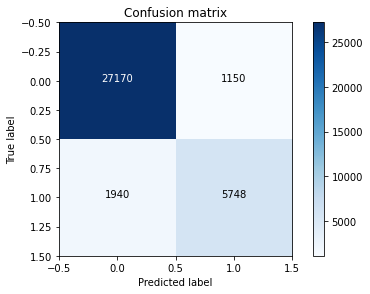

In [70]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_val, y_val_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True, 
                      title='Normalized confusion matrix')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix)

Normalized confusion matrix
[[0.96 0.04]
 [0.33 0.67]]
Confusion matrix, without normalization
[[27154  1166]
 [ 2504  5184]]


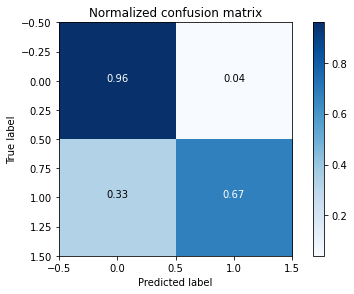

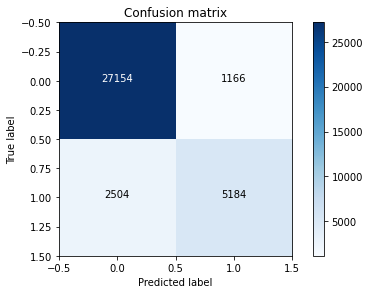

In [71]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_val, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True, 
                      title='Normalized confusion matrix')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix)

In [ ]:
def evaluate_model(X_, y_, model_):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    scores = cross_val_score(model_, X_, y_, scoring='f1', cv=cv, n_jobs=-1)
    return scores

In [ ]:
model = RandomForestClassifier()
scores = evaluate_model(x_train_scaled, y_train, model)
# print('Mean Accuracy No weight:', (scores))
print('Mean Accuracy No weight: %.3f (%.3f)' % (mean(scores), std(scores)))

In [76]:
model = RandomForestClassifier()
model.fit(x_train_scaled, y_train)
y_pred = model.predict(x_val_scaled)

Normalized confusion matrix
[[0.08 0.92]
 [0.02 0.98]]
Confusion matrix, without normalization
[[ 2152 26168]
 [  179  7509]]


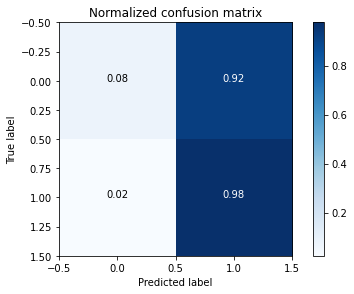

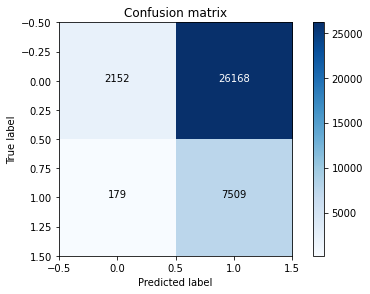

In [77]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_val, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True, 
                      title='Normalized confusion matrix')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix)

In [78]:
y_test_pred = model.predict(X_test_scaled)

Normalized confusion matrix
[[0.11 0.89]
 [0.01 0.99]]
Confusion matrix, without normalization
[[ 3730 31665]
 [  104  9512]]


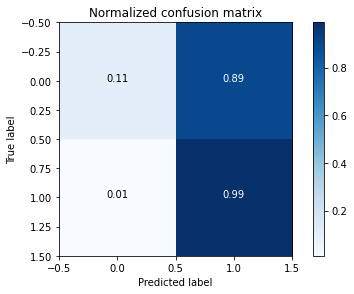

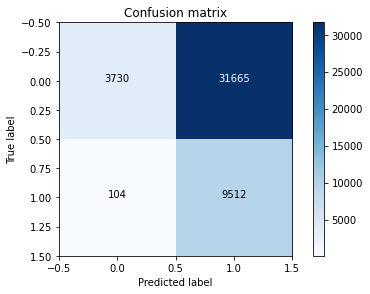

In [79]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(Y_test, y_test_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True, 
                      title='Normalized confusion matrix')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix)

In [44]:
weights = {0:1.0, 1:2.0}
model = RandomForestClassifier(n_estimators=1000, class_weight=weights)
# scores = evaluate_model(x_train_scaled, y_train, model)
# print('Mean Accuracy    weight: %.3f (%.3f)' % (mean(scores), std(scores)))

In [45]:
model.fit(x_train_scaled, y_train)
y_pred = model.predict(x_val_scaled)

Normalized confusion matrix
[[0.96 0.04]
 [0.33 0.67]]
Confusion matrix, without normalization
[[27154  1166]
 [ 2504  5184]]


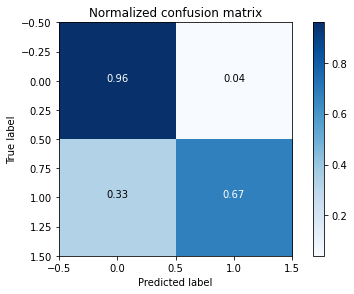

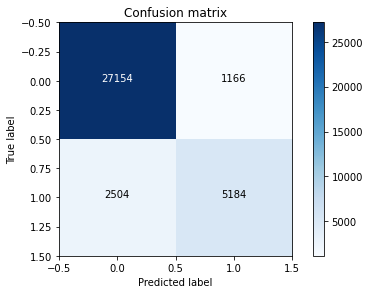

In [46]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_val, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True, 
                      title='Normalized confusion matrix')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix)

In [48]:
y_test_pred = model.predict(X_test_scaled)

Normalized confusion matrix
[[0.98 0.02]
 [0.54 0.46]]
Confusion matrix, without normalization
[[34708   687]
 [ 5193  4423]]


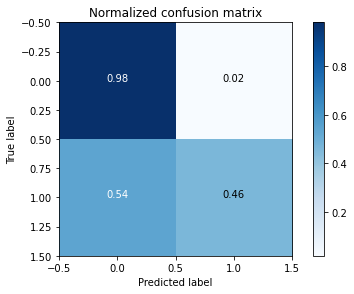

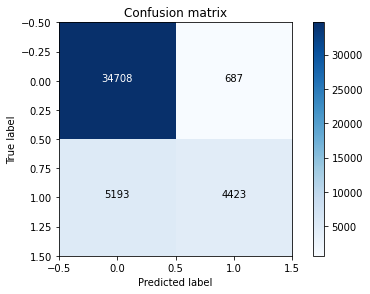

In [50]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(Y_test, y_test_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True, 
                      title='Normalized confusion matrix')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix)

In [47]:
def eval_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    plt.figure()
    plot_confusion_matrix(cnf_matrix, normalize=True, 
                          title='Normalized confusion matrix')

    plt.figure()
    plot_confusion_matrix(cnf_matrix)

In [38]:
import itertools
def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks( rotation=45)
#     plt.yticks(tick_marks)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_val, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True, 
                      title='Normalized confusion matrix')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix)

In [ ]:
y_test_pred = model.predict(X_test_scaled)

In [ ]:
len(y_test_pred)

In [ ]:
len(y_test)

In [ ]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(Y_test, y_test_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True, 
                      title='Normalized confusion matrix')
plt.figure()
plot_confusion_matrix(cnf_matrix)

## Handling Imbalanced Data


In [ ]:
df = train_df.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = train_df.train_df[df['Segment'] == 1]
non_fraud_df = train_df.train_df[df['Segment'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

In [ ]:
X_train = train.drop(['ad_id', 'eCPM', 'eCPM_class', 'Segment'], axis=1)
Y_train = train[['Segment']]

X_val = validation.drop(['ad_id', 'eCPM', 'eCPM_class', 'Segment'], axis=1)
Y_val = validation[['Segment']]

In [ ]:
print(len(X_train))
print(len(y_train))
print(len(X_val))
print(len(y_val))

In [ ]:
y_val.isnull().sum()

In [ ]:
def scaler(data, scaling_method):
    if scaling_method == 'Normalizer':
        scaler = Normalizer()
    elif scaling_method == 'MinMaxScaler':
        scaler = MinMaxScaler()
    elif scaling_method == 'StandardScaler':
        scaler = StandardScaler()
    elif scaling_method == 'RobustScaler':
        scaler = RobustScaler()
        
    data_scaled = scaler.fit_transform(data)
    return data_scaled

In [ ]:
def feature_select(x_train, y_train, x_test , y_test, model):
    ## feature select
    selector = SelectFromModel(estimator = model).fit(x_train, y_train) #estimator 여기에 사용하고 싶은 모델 넣기
    selector_feat= x_train.columns[(selector.get_support())] #뽑힌 column
    print('------- selected feature ----------')
    print(selector_feat)
    
    return selector_feat

In [ ]:
def result_plot(y_test, y_pred):
    fig = plt.figure(figsize=(30,10))
    chart = fig.add_subplot(1,1,1)
    chart.plot(y_test.values, marker='o', color='blue', label='Actual')
    chart.plot(y_pred, marker='^', color='red', label='Predict')
    plt.legend(loc='best')

In [ ]:
def result_sub_plot(y_test, y_pred):
    fig = plt.figure(figsize=(30,10))
    chart = fig.add_subplot(1,1,1)
    chart.plot(y_test[:300].values, marker='o', color='blue', label='Actual')
    chart.plot(y_pred[:300], marker='^', color='red', label='Predict')
    plt.legend(loc='best')

## Normalizer

In [ ]:
#컬럼명저장
X_cols = X_train.columns

#scaling
X_train = scaler(X_train, 'Normalizer')
X_test = scaler(X_val, 'Normalizer')

#dataframe으로 다시저장
X_train = pd.DataFrame(X_train, columns=X_cols.tolist())
X_val = pd.DataFrame(X_val, columns=X_cols.tolist())

In [ ]:
print(len(X_train))
print(len(X_val))

In [ ]:
model = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l2'))

In [ ]:
selected_features = feature_select(X_train, y_train, X_val, y_val, model)

In [ ]:
clf = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l2'))
clf.fit(X_train[selected_features], y_train)
y_pred = clf.predict(X_val[selected_features])

In [ ]:
print("Accuracy :",metrics.accuracy_score(y_val,y_pred))
print("Macro f1 score :",metrics.f1_score(y_val, y_pred, average = 'macro'))
print("Micro f1 score :",metrics.f1_score(y_val, y_pred, average = 'micro'))
print("Hamming loss :",metrics.hamming_loss(y_val,y_pred))

In [ ]:
print(metrics.classification_report(y_val,y_pred))

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_val,y_pred)
np.set_printoptions(precision=2)

class_names = ['High-Value', 'Low-Value', 'Mid-Value']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, 
                      title='Normalized confusion matrix')

## Regression

In [ ]:
model_xgb = xgb.XGBRegressor()

In [ ]:
y_train

In [ ]:
result = embedded_predict(X_train, y_train, X_val, y_val, model=model_xgb)

In [ ]:
result_plot(ba_val, result)

In [ ]:
result_sub_plot(ba_val, result)

In [ ]:
model_xgb = xgb.XGBRegressor()
result = embedded_predict(X_train, is_train, X_val, is_val, model=model_xgb)
result_plot(is_val, result)
result_sub_plot(is_val, result)

In [ ]:
model_xgb = xgb.XGBRegressor()
result = embedded_predict(X_train, rv_train, X_val, rv_val, model=model_xgb)
result_plot(rv_val, result)
result_sub_plot(rv_val, result)

In [ ]:
model_xgb = xgb.XGBRegressor()
result = embedded_predict(X_train, all_train, X_val, all_val, model=model_xgb)
result_plot(all_val, result)
result_sub_plot(all_val, result)

## RobustScaler

In [ ]:
#컬럼명저장
X_cols = X_train.columns

#scaling
X_train = scaler(X_train, 'RobustScaler')
X_test = scaler(X_val, 'RobustScaler')

#dataframe으로 다시저장
X_train = pd.DataFrame(X_train, columns=X_cols.tolist())
X_val = pd.DataFrame(X_val, columns=X_cols.tolist())

In [ ]:
ba_train = y_train[['ba_imps_234567']]
is_train = y_train[['is_imps_234567']]
rv_train = y_train[['rv_imps_234567']]
all_train = y_train['ba_imps_234567'] + y_train['is_imps_234567'] + y_train['rv_imps_234567']

In [ ]:
ba_val = y_val[['ba_imps_234567']]
is_val = y_val[['is_imps_234567']]
rv_val = y_val[['rv_imps_234567']]
all_val = y_val['ba_imps_234567'] + y_val['is_imps_234567'] + y_val['rv_imps_234567']

In [ ]:
model_xgb = xgb.XGBRegressor()
result = embedded_predict(X_train, ba_train, X_val, ba_val, model=model_xgb)
result_plot(ba_val, result)
result_sub_plot(ba_val, result)

In [ ]:
model_xgb = xgb.XGBRegressor()
result = embedded_predict(X_train, is_train, X_val, is_val, model=model_xgb)
result_plot(is_val, result)
result_sub_plot(is_val, result)

In [ ]:
model_xgb = xgb.XGBRegressor()
result = embedded_predict(X_train, rv_train, X_val, rv_val, model=model_xgb)
result_plot(rv_val, result)
result_sub_plot(rv_val, result)

In [ ]:
model_xgb = xgb.XGBRegressor()
result = embedded_predict(X_train, all_train, X_val, all_val, model=model_xgb)
result_plot(all_val, result)
result_sub_plot(all_val, result)